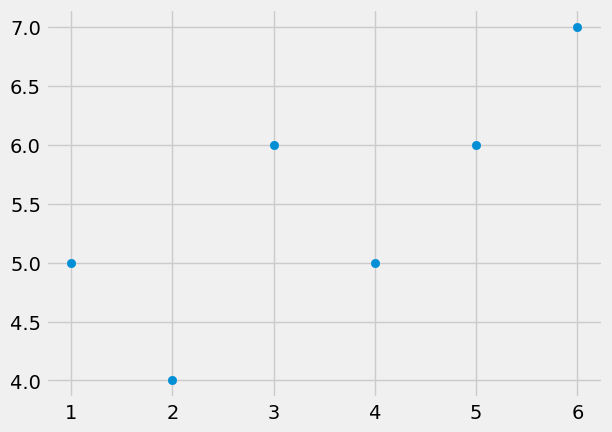

In [26]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import random

style.use('fivethirtyeight')

def create_dataset(hm, variance, step=2, correlation=False):
    val = 1 
    ys = []
    for i in range(hm): 
        y = val + random.randrange(-variance, variance)
        ys.append(y)
        if correlation and correlation == 'pos':
            val+=step
        elif correlation and correlation == 'neg':
            val-= step
    xs = [i for i in range(len(ys))]
    
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

xs = np.array([1, 2, 3, 4, 5, 6], dtype=np.float64)
ys = np.array([5, 4, 6, 5, 6, 7], dtype=np.float64)

plt.scatter(xs, ys)
plt.show()

In [35]:
def best_fit_slope_and_intercept(xs, ys):
    m = ( ( (mean(xs) * mean(ys)) - mean(xs*ys) ) /
            ((mean(xs)**2) - mean(xs**2)))
    
    b = mean(ys) - m*mean(xs)     
    return m, b

def squared_error(ys_true, ys_predict):
    return sum((ys_predict-ys_true)**2)

def coefficient_of_determination(ys_true, ys_predict):
    y_mean_line = [mean(ys_true) for y in ys_true]
    squared_error_regr = squared_error(ys_true, ys_predict)
    squared_error_y_mean = squared_error(ys_true, y_mean_line)
    return 1-(squared_error_regr / squared_error_y_mean)

xs, ys = create_dataset(40, 80, 2, correlation='pos')
m, b = best_fit_slope_and_intercept(xs, ys)


0.3662113940568933


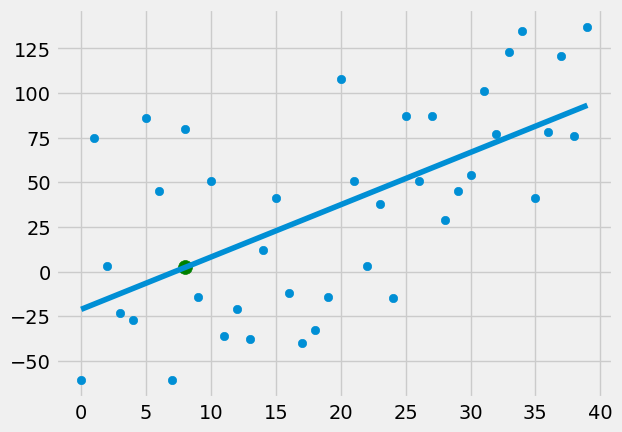

In [36]:
predict_x = 8
predict_y = (m*predict_x)+b

regression_line = [(m*x)+b for x in xs]

r_squared = coefficient_of_determination(ys, regression_line) 
print(r_squared)

plt.scatter(xs, ys)
#plt.scatter(predict_x, predict_y, color='g')
plt.plot(xs, regression_line)
plt.scatter(predict_x, predict_y, s=100, color='g')
plt.show()